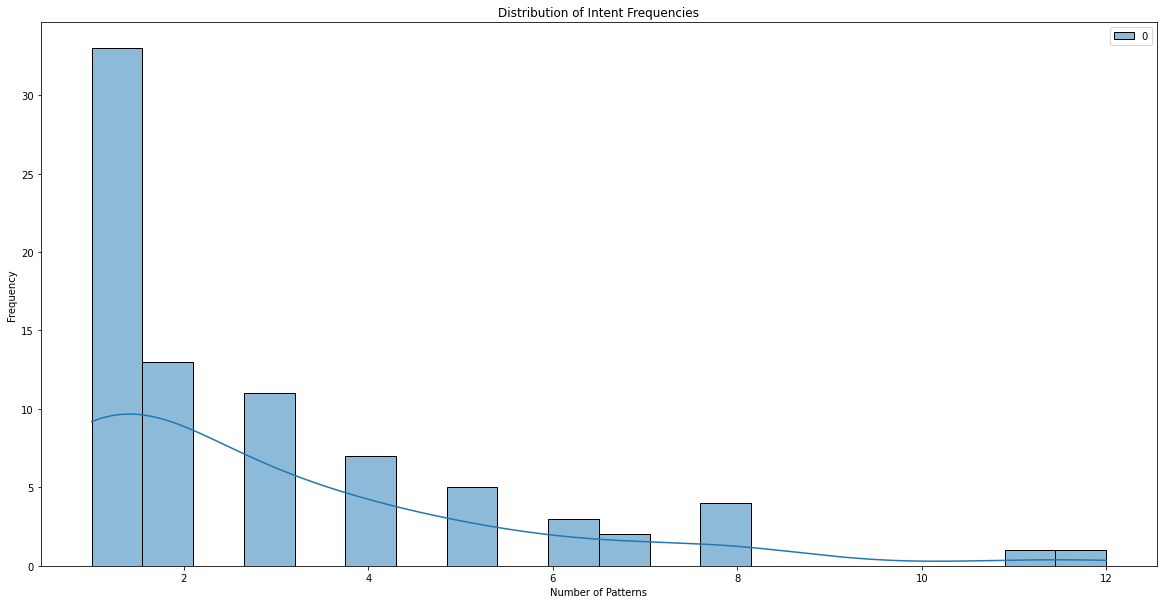

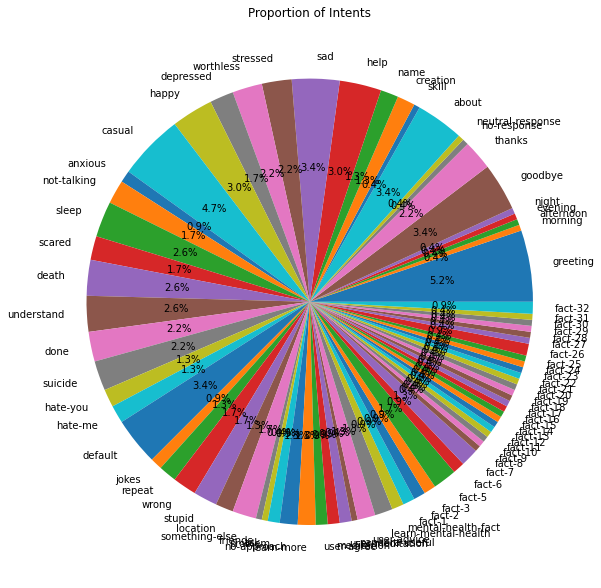

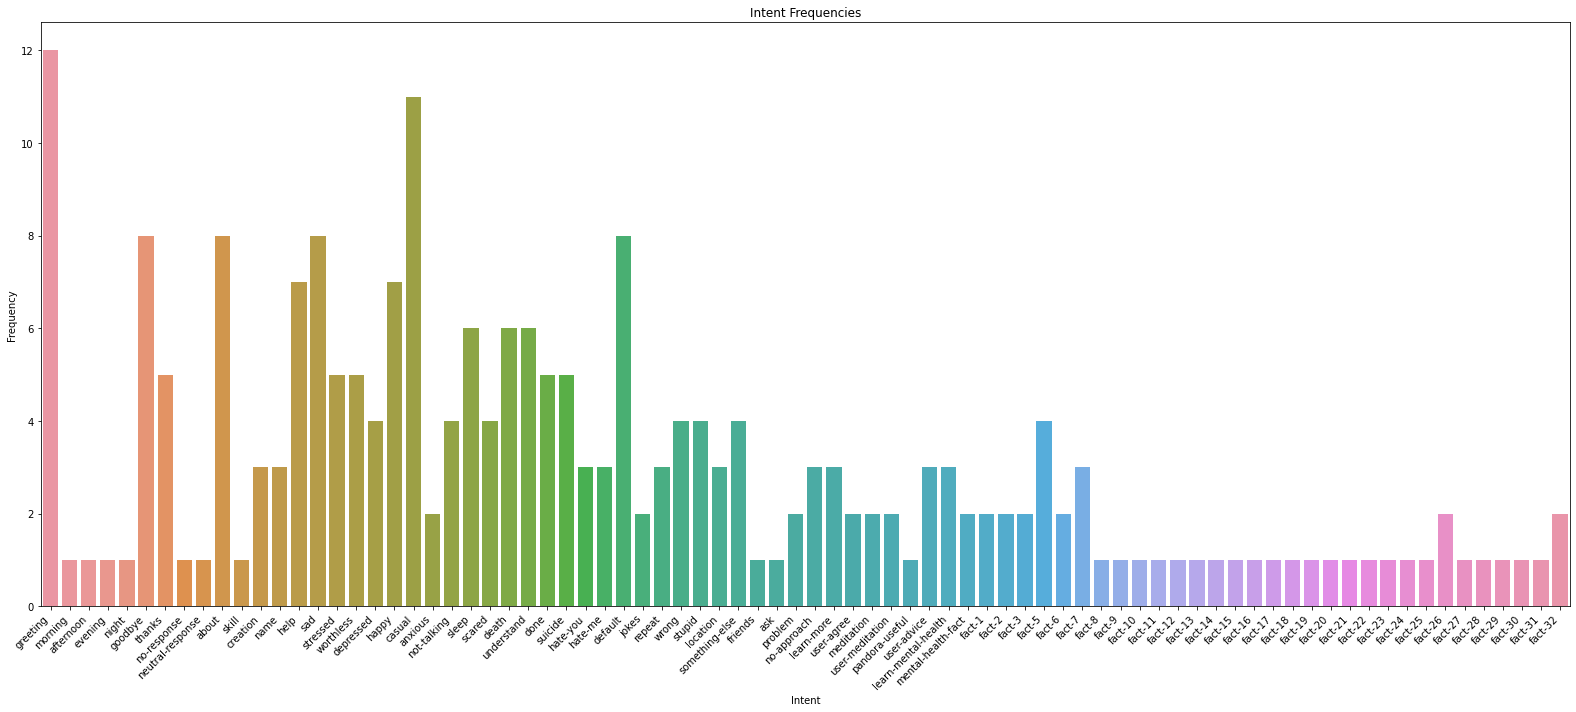

In [34]:
import json
import matplotlib.pyplot as plt
import seaborn as sns


# Load intents from JSON file
intents_file_path = "C:\\Users\\pc\\Documents\\Data_Science\\CHATBOT\\data\\intents.json"
with open(intents_file_path, 'r') as f:
    intents = json.load(f)

# Extract intents from the loaded data
intent_labels = [intent['tag'] for intent in intents['intents']]

# Count the frequency of each intent
intent_counts = {}
for intent in intents['intents']:
    intent_counts[intent['tag']] = len(intent['patterns'])

# Plot histogram of intent frequencies
plt.figure(figsize=(20, 10))
sns.histplot(intent_counts.values(), bins=20, kde=True)
plt.title('Distribution of Intent Frequencies')
plt.xlabel('Number of Patterns')
plt.ylabel('Frequency')
plt.show()

# Plot pie chart of intent proportions
plt.figure(figsize=(10, 500))
plt.pie(intent_counts.values(), labels=intent_counts.keys(), autopct='%1.1f%%')
plt.title('Proportion of Intents')
plt.show()

# Plot bar plot of intent frequencies
plt.figure(figsize=(22, 10))
sns.barplot(x=list(intent_counts.keys()), y=list(intent_counts.values()))
plt.title('Intent Frequencies')
plt.xlabel('Intent')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [35]:
import json
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from nltk import word_tokenize, PorterStemmer

# Load intents from JSON file
import json

# Specify the full path to the intents.json file
intents_file_path = "C:\\Users\\pc\\Documents\\Data_Science\\CHATBOT\\data\\intents.json"

# Load intents from JSON file
with open(intents_file_path, 'r') as f:
    intents = json.load(f)

# Rest of your code...


# Preprocess data
all_words = []
tags = []
xy = []
stemmer = PorterStemmer()

for intent in intents['intents']:
    tag = intent['tag']
    tags.append(tag)
    for pattern in intent['patterns']:
        # Tokenize and stem each word
        words = [stemmer.stem(word.lower()) for word in word_tokenize(pattern)]
        all_words.extend(words)
        xy.append((words, tag))

# Remove duplicates and sort
all_words = sorted(set(all_words))
tags = sorted(set(tags))

# Create training data
X_train = []
y_train = []
for (pattern_words, tag) in xy:
    # Create bag of words
    bag = [1 if word in pattern_words else 0 for word in all_words]
    X_train.append(bag)
    # Encode tag
    label = tags.index(tag)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Define dataset and dataloader
class ChatDataset(Dataset):
    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = torch.tensor(X_train, dtype=torch.float32)
        self.y_data = torch.tensor(y_train, dtype=torch.long)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.n_samples

# Define neural network model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

# Hyperparameters
input_size = len(X_train[0])
hidden_size = 8
output_size = len(tags)
batch_size = 8
learning_rate = 0.001
num_epochs = 1000

# Initialize dataset and dataloader
dataset = ChatDataset()
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss function, and optimizer
model = NeuralNet(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for (words, labels) in train_loader:
        # Forward pass
        outputs = model(words)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 100 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save trained model
torch.save(model.state_dict(), 'chatbot_model.pth')
print('Training complete. Model saved.')

# Chatbot interface
print("Type 'quit' to exit.")
while True:
    user_input = input("You: ")
    if user_input.lower() == 'quit':
        break
    # Preprocess user input
    input_words = [stemmer.stem(word.lower()) for word in word_tokenize(user_input)]
    # Create bag of words
    input_bag = np.array([1 if word in input_words else 0 for word in all_words])
    # Convert to tensor
    input_tensor = torch.tensor(input_bag, dtype=torch.float32).unsqueeze(0)
    # Get prediction from model
    output = model(input_tensor)
    _, predicted = torch.max(output, dim=1)
    tag = tags[predicted.item()]
    # Find appropriate response
    for intent in intents['intents']:
        if intent['tag'] == tag:
            responses = intent['responses']
            print("Bot:", random.choice(responses))
            break


Epoch [100/1000], Loss: 0.3733
Epoch [200/1000], Loss: 0.0135
Epoch [300/1000], Loss: 0.0049
Epoch [400/1000], Loss: 0.0011
Epoch [500/1000], Loss: 0.0002
Epoch [600/1000], Loss: 0.0001
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0000
Training complete. Model saved.
Type 'quit' to exit.
You: how are you feeling today
Bot: You can call me Pandora.
You: quit


In [36]:
!pip install transformers
import json
import random
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load intents from JSON file
intents_file_path = "C:\\Users\\pc\\Documents\\Data_Science\\CHATBOT\\data\\intents.json"

# Load intents from JSON file
with open(intents_file_path, 'r') as f:
    intents = json.load(f)

# Preprocess data
responses = {}
for intent in intents['intents']:
    tag = intent['tag']
    responses[tag] = intent['responses']

# Load pre-trained GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Chatbot interface
print("Type 'quit' to exit.")
while True:
    user_input = input("You: ")
    if user_input.lower() == 'quit':
        break
    # Tokenize user input
    input_ids = tokenizer.encode(user_input, return_tensors='pt')
    # Generate response
    response = model.generate(input_ids, max_length=100, num_return_sequences=1, temperature=0.7)
    # Decode and print response
    decoded_response = tokenizer.decode(response[0], skip_special_tokens=True)
    print("Bot:", decoded_response)


Type 'quit' to exit.
You: how are you feeling today


C:\Users\pc\anaconda3\lib\site-packages\transformers\generation\configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Bot: how are you feeling today?"

"I'm feeling better. I'm feeling better. I'm feeling better. I'm feeling better. I'm feeling better. I'm feeling better. I'm feeling better. I'm feeling better. I'm feeling better. I'm feeling better. I'm feeling better. I'm feeling better. I'm feeling better. I'm feeling better. I'm feeling better. I'm feeling better. I'm feeling better. I'm feeling better. I
You: are you anxious


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Bot: are you anxious about the future?

I'm not. I'm not worried about the future. I'm not worried about the future. I'm not worried about the future. I'm not worried about the future. I'm not worried about the future. I'm not worried about the future. I'm not worried about the future. I'm not worried about the future. I'm not worried about the future. I'm not worried about the future. I'm not worried about the future
You: quit
